In [1]:
import sympy
import numpy as np
import time
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import networkx as nx
import pickle
from scipy.signal import savgol_filter

from dataclasses import dataclass
from typing import List, Tuple

from ConservationLaws import *


In [100]:
L = sympy.Matrix([
    [1, 2, 0, 1, 0],
    [0, 0, 1, 0, 1]
])

# L = sympy.Matrix([
#     [1, 0, 0, 1, 1, 0],
#     [0, 1, 0, 0, 1, 1],
#     [0, 0, 1, 1, 0, 1],
# ])

# L = sympy.Matrix([
#     [1, 1, 1, 1, 1, 1],
# ])

n_species = 5
n_cons = 2
L = random_conservation_laws(n_cons, n_species, mc=2, seed=None)
print(L)
n_reactions = 4
n_species = L.shape[1]

### check that there are no accidental conservation laws
reac_order = 2

seed = np.random.randint(0, 1000000)

A = generate_stoichiometry_matrix(L, n_reactions, reac_order=reac_order, seed=seed)
sympy.pprint(A)

S, k, odes, reaction_network, rate_exprs = build_mass_action_odes(A, Reaction)
print(odes)
print_reaction_network(reaction_network)

Matrix([[2, 2, 0, 2, 2], [1, 0, 0, 1, 1]])
⎡1   2   1   -1⎤
⎢              ⎥
⎢0   0   0   0 ⎥
⎢              ⎥
⎢1   0   0   1 ⎥
⎢              ⎥
⎢0   0   -1  0 ⎥
⎢              ⎥
⎣-1  -2  0   1 ⎦
[-S1*k4 + S4*k3 + 2*S5**2*k2 + S5*k1, 0, S1*k4 + S5*k1, -S4*k3, S1*k4 - 2*S5**2*k2 - S5*k1]
R1: S5 -> S1 + S3
R2: S5 + S5 -> S1 + S1
R3: S4 -> S1
R4: S1 -> S3 + S5


In [76]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Suppose S = (S1, S2, ..., S5), k = (k1, ..., k7)
# odes is a list of sympy expressions in S and k

# Create a function for the right-hand side
ode_func = sympy.lambdify((S, k), odes, modules='numpy')

def rhs(t, y, k_values):
    # y: concentrations at time t
    # k_values: array of rate constants
    return np.array(ode_func(y, k_values)).flatten()


# Example initial concentrations and rate constants
#y0 = [1.0, 0.5, 0.2, 1.0, 0.2, 0.5]  # adjust as needed

y0 = 2 * np.random.rand(n_species)
print(y0)
k_values = 5 * np.random.rand(n_reactions)
t_span = (0, 50)                 # time interval
dt = 0.001
t_eval = np.linspace(*t_span, int(t_span[1]/dt))  # evaluate at 1000 points (dt = 0.2)

[1.83816744 0.40326433 0.79023005 1.74082522 1.98182282 0.45838118]


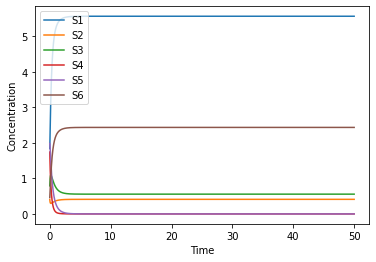

In [77]:



for i in range(n_species):
    plt.plot(sol.t, sol.y[i], label=f'S{i+1}')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

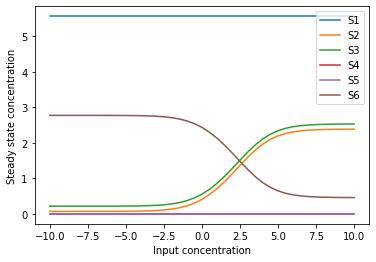

In [83]:
t_span = (0, 500)                 # time interval
dt = 0.01
t_eval = np.linspace(*t_span, int(t_span[1]/dt))  # evaluate at 1000 points (dt = 0.2)

#k_values = 5 * np.random.rand(n_reactions)

# input_type = 'concentration'
# input_idx = 1
# dv = 0.1
# crange = 10
# input_vals =  np.linspace(0, crange, int(crange/dv))

input_type = 'rate'
input_idx = 0
input_vals =  np.linspace(-10, 10, 41)


ss_response = compute_ss_response_as_function_of_input(rhs, k_values, y0, t_eval, input_type, input_idx, input_vals)

for i in range(ss_response.shape[1]):
    plt.plot(input_vals, ss_response[:, i], label=f'S{i+1}')
plt.xlabel('Input concentration')
plt.ylabel('Steady state concentration') 
plt.legend()



In [84]:
count_turning_points_columns(ss_response, eps=1e-6)



array([0., 0., 0., 0., 0., 0.])

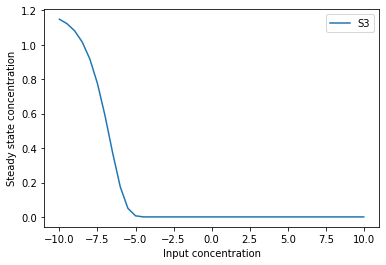

In [63]:
plt.plot(input_vals[:], ss_response[:, 4], label=f'S{2+1}')
plt.xlabel('Input concentration')
plt.ylabel('Steady state concentration') 
plt.legend()

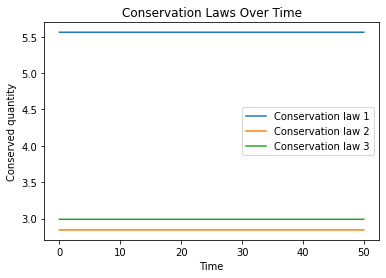

In [85]:
# If L is a sympy Matrix, convert to numpy
L_np = np.array(L).astype(float)  # shape: (n_laws, n_species)
S_sol = sol.y                     # shape: (n_species, n_timepoints)

# Compute conserved quantities at each timepoint
Q = L_np @ S_sol  # shape: (n_laws, n_timepoints)

# Plot each conserved quantity over time
for i in range(Q.shape[0]):
    plt.plot(sol.t, Q[i], label=f'Conservation law {i+1}')
plt.xlabel('Time')
plt.ylabel('Conserved quantity')
plt.legend()
plt.title('Conservation Laws Over Time')
plt.show()

In [71]:
# --- Simulation and Analysis of Random Reaction Networks ---

num_reps = 100

# Parameters for the system
n_cons = 1           # Number of conservation laws
n_reactions = 10      # Number of reactions
n_species = 6       # Number of species
force_reverse_reactions = False  # Force all reactions to have a reverse reaction
k_fac = 2 if force_reverse_reactions else 1  # Factor to account for reverse reactions in rate constant generation

# Random seed for reproducibility
seed = np.random.randint(0, 1000000)

seed = 15
seed = 200
np.random.seed(seed)

# Probability distribution for conservation law entries (e.g., [2,2] means 0 and 1 equally likely)
# reac_order = 1
# probs = np.array([2, 2])
# probs = probs / sum(probs)

reac_order = 2
probs = np.array([8, 6, 2])
probs = probs / sum(probs)

method = 'LSODA'
rtol = 1e-3
atol = 1e-6 

# reac_order = 2
# probs = np.array([10, 2, 2])
# probs = probs / sum(probs)

# Timeouts for random search
outer_timeout = 40   # seconds for the outer loop
inner_timeout = 1    # seconds for the inner loop in generate_stoichiometry_matrix

# Magnitude for initial conditions and rate constants
y_mag = 2
k_mag = 2

# Time span and evaluation points for ODE integration
t_span = (0, 30)  # time interval
dt = 2.5e-4
# Number of time points to evaluate
t_eval = np.linspace(*t_span, int(t_span[1]/dt))

# Input perturbation settings
input_type = 'rate'  # or 'concentration'
input_range = k_fac * n_reactions  # number of possible input indices
input_vals = np.linspace(-10, 10, 41)  # range of input values to scan


# --- Randomly generate valid conservation laws and stoichiometry matrix ---
success = False
start_time = time.time()
while not success:
    # Sample random conservation laws matrix
    L = random_conservation_laws(n_cons, n_species, probs, seed=None)
    try:
        # Try to generate a valid stoichiometry matrix
        A = generate_stoichiometry_matrix(L, n_reactions, reac_order=reac_order, force_reverse_reactions=force_reverse_reactions, seed=None, timeout=inner_timeout)
        success = True  # Only set to True if no error is raised
    except ValueError as e:
        # If time limit exceeded, raise error
        if time.time() - start_time > outer_timeout:
            raise ValueError("Timeout reached while running outer loop.")
        continue  # Otherwise, try again

end_time = time.time()
# print(f"Time taken to generate stoichiometry matrix: {end_time - start_time} seconds")
# --- Build ODEs and reaction network ---
S, k, odes, reaction_network, rate_exprs = build_mass_action_odes(A, Reaction)

# --- Set up initial conditions and rate constants ---
y0 = y_mag * np.random.rand(n_species)
k_values = k_mag * np.random.rand(k_fac * n_reactions)

# Lambdify ODEs for numerical integration
ode_func = sympy.lambdify((S, k), odes, modules='numpy')
def rhs(t, y, k_values):
    return np.array(ode_func(y, k_values)).flatten()

ss_responses = []
for input_idx in range(input_range):
    ss_response = compute_ss_response_as_function_of_input(rhs, k_values, y0, t_span, t_eval, input_type, input_idx, input_vals, method = method, rtol = rtol, atol = atol)
    ss_responses.append(ss_response)

#print(sum(sum(turning_points)))


[0. 0. 0. 0. 0. 0.]


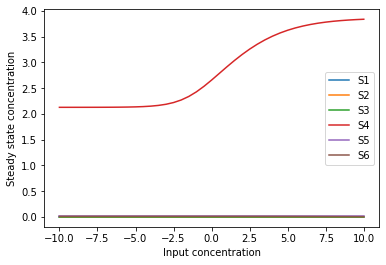

In [42]:
ss_ind = 8

for i in range(ss_responses[ss_ind].shape[1]):
    plt.plot(input_vals, ss_responses[ss_ind][:, i], label=f'S{i+1}')

tp = count_turning_points_columns(ss_responses[ss_ind], eps=1e-3, smooth=True, window_length=5, polyorder=1, prominence=1e-3, wlen=5)
print(tp)
# ss_ind = -1
# k_ind = 0
# plt.plot(input_vals, ss_responses[ss_ind][:, k_ind], label=f'S{k_ind+1}')

plt.xlabel('Input concentration')
plt.ylabel('Steady state concentration')
plt.legend()

Graph is strongly connected: False


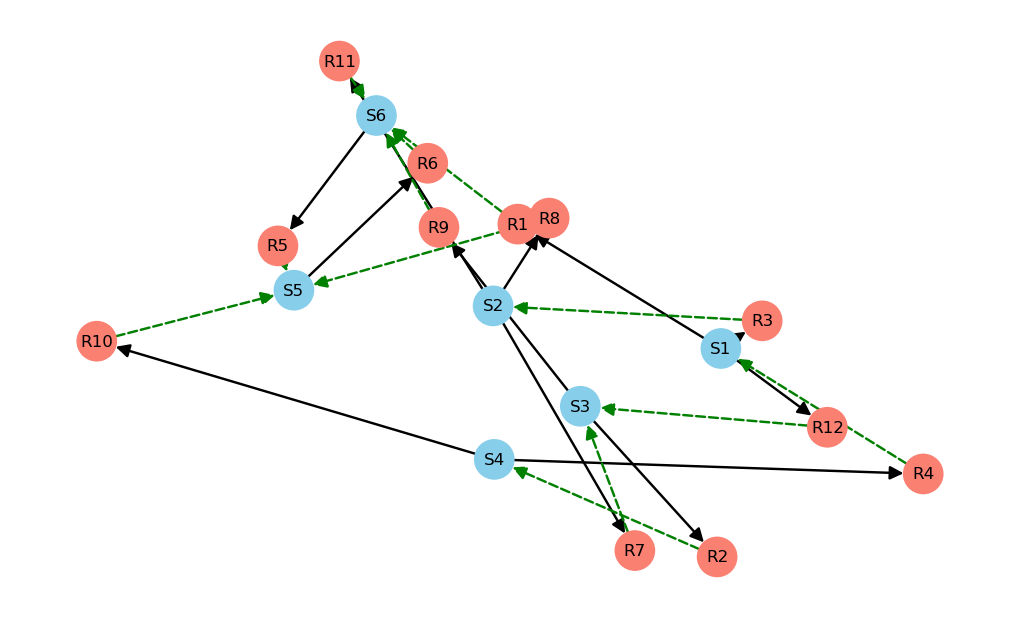

In [120]:
G = reaction_network_to_bipartite_graph(reaction_network, n_species)
#top = nx.bipartite.sets(G)[0]


# Create color map after graph is created
color_map = []
for node in G.nodes():
    if node.startswith('S'):  # Species nodes
        color_map.append('skyblue')
    else:  # Reaction nodes
        color_map.append('salmon')

edge_colors = []
edge_widths = []
edge_styles = []
for u, v in G.edges():
    if u.startswith('S') and v.startswith('R'):
        edge_colors.append('black')
        edge_widths.append(1.75)
        edge_styles.append('solid')
    elif u.startswith('R') and v.startswith('S'):
        edge_colors.append('green')
        edge_widths.append(1.75)
        edge_styles.append('dashed')

#pos = nx.bipartite_layout(G, top)
pos = nx.spring_layout(G)
#pos = nx.spiral_layout(G)

# Note: nx.draw does not support per-edge style directly, but you can use nx.draw_networkx_edges for more control:
plt.figure(figsize=(10, 6))

print("Graph is strongly connected:", nx.is_strongly_connected(G))
nx.draw(
    G, pos,
    with_labels=True,
    node_color=color_map,
    edge_color=edge_colors,
    width=edge_widths,
    style=edge_styles,
    node_size=800,
    arrows=True,
    arrowsize=20  # <-- Increase this value for larger arrows (default is 10)
)
plt.show()

In [95]:
from concurrent.futures import ProcessPoolExecutor

# --- Simulation and Analysis of Random Reaction Networks ---

num_reps = 100

# Parameters for the system
n_cons = 1           # Number of conservation laws
n_reactions = 10      # Number of reactions
n_species = 6       # Number of species
force_reverse_reactions = False  # Force all reactions to have a reverse reaction
k_fac = 2 if force_reverse_reactions else 1  # Factor to account for reverse reactions in rate constant generation

# Random seed for reproducibility
seed = np.random.randint(0, 1000000)

seed = 15
np.random.seed(seed)

# Probability distribution for conservation law entries (e.g., [2,2] means 0 and 1 equally likely)
reac_order = 1
probs = np.array([2, 200])
probs = probs / sum(probs)

method = 'LSODA'
rtol = 1e-2
atol = 1e-2

# reac_order = 2
# probs = np.array([10, 2, 2])
# probs = probs / sum(probs)

# Timeouts for random search
outer_timeout = 10   # seconds for the outer loop
inner_timeout = 1    # seconds for the inner loop in generate_stoichiometry_matrix

# Magnitude for initial conditions and rate constants
y_mag = 5
k_mag = 10

# Time span and evaluation points for ODE integration
t_span = (0, 40)  # time interval
dt = 0.005
# Number of time points to evaluate
t_eval = np.linspace(*t_span, int(t_span[1]/dt))

# Input perturbation settings
input_type = 'rate'  # or 'concentration'
input_range = n_reactions  # number of possible input indices
input_vals = np.linspace(-10, 10, 41)  # range of input values to scan

# input_type = 'concentration'
# input_range = n_species  # number of possible input indices
# dv = 0.02
# crange = 5
# input_vals =  np.linspace(0, crange, int(crange/dv))

S_list = []
k_list = []
odes_list = []
reaction_network_list = []
turning_points_list = []
ss_response_list = []
G_list = []

for rep in range(num_reps):

    # --- Randomly generate valid conservation laws and stoichiometry matrix ---
    success = False
    start_time = time.time()
    while not success:
        # Sample random conservation laws matrix
        L = random_conservation_laws(n_cons, n_species, probs, seed=None)
        try:
            # Try to generate a valid stoichiometry matrix
            A = generate_stoichiometry_matrix(L, n_reactions, reac_order=reac_order, force_reverse_reactions=force_reverse_reactions, seed=None, timeout=inner_timeout)
            success = True  # Only set to True if no error is raised
        except ValueError as e:
            # If time limit exceeded, raise error
            if time.time() - start_time > outer_timeout:
                raise ValueError("Timeout reached while running outer loop.")
            continue  # Otherwise, try again
    
    end_time = time.time()
    # print(f"Time taken to generate stoichiometry matrix: {end_time - start_time} seconds")
    # --- Build ODEs and reaction network ---
    S, k, odes, reaction_network, rate_exprs = build_mass_action_odes(A, Reaction)

    # --- Set up initial conditions and rate constants ---
    y0 = y_mag * np.random.rand(n_species)
    k_values = k_mag * np.random.rand(k_fac * n_reactions)

    # Lambdify ODEs for numerical integration
    ode_func = sympy.lambdify((S, k), odes, modules='numpy')

    ss_responses = []
    turning_points = []
    for input_idx in range(input_range):
        ss_response = compute_ss_response_as_function_of_input(rhs, k_values, y0, t_eval, input_type, input_idx, input_vals, method = method, rtol = rtol, atol = atol)
        ss_responses.append(ss_response)
        turning_points.append(count_turning_points_columns(ss_response, eps=1e-2))


    G = reaction_network_to_bipartite_graph(reaction_network, n_species)
    
    S_list.append(S)
    k_list.append(k)
    odes_list.append(odes)
    reaction_network_list.append(reaction_network)
    turning_points_list.append(turning_points)
    ss_response_list.append(ss_responses)
    G_list.append(G)

    if rep%10 == 0:
        print(rep)




0
10
20
30
40
50
60
70
80
90


In [ ]:
path = '/Users/csfloyd/Dropbox/Projects/GlycanAnalysis/PythonOutput/NSC_FO.apkl'
export_data_as_apkl(path, S_list, k_list, odes_list, reaction_network_list, ss_response_list, G_list)

data = import_data_from_apkl(path)
S_list = data['S_list']
k_list = data['k_list']
odes_list = data['odes_list']
reaction_network_list = data['reaction_network_list']
ss_response_list = data['ss_response_list']
G_list = data['G_list']


Data exported to /Users/csfloyd/Dropbox/Projects/GlycanAnalysis/PythonOutput/NSC_FO.apkl


In [ ]:
turning_points_list = recompute_turning_points_list(ss_response_list, eps=1e-2, smooth=True)
print([sum(sum(turning_points)) for turning_points in turning_points_list])
print(sum([sum(sum(turning_points)) for turning_points in turning_points_list]))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 1.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 4.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0]
30.0


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 1.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 4.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, F

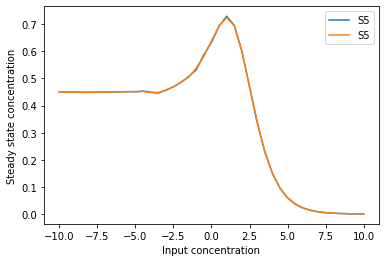

In [144]:
print([sum(sum(turning_points)) for turning_points in turning_points_list])
print([nx.is_strongly_connected(G) for G in G_list])

trial_ind = -10
print(np.array(turning_points_list[trial_ind]))


# ## --- Plot steady-state response curves ---
# ss_ind = 4
# for i in range(ss_responses[ss_ind].shape[1]):
#     plt.plot(input_vals, ss_responses[ss_ind][:, i], label=f'S{i+1}')

ss_ind = 0
k_ind = 4
y = ss_response_list[trial_ind][ss_ind][:, k_ind]
plt.plot(input_vals, y, label=f'S{k_ind+1}')

y_smooth = smooth_curve(y)
print(count_turning_points(y_smooth, eps=1e-2))
plt.plot(input_vals, y_smooth, label=f'S{k_ind+1}')

plt.xlabel('Input concentration')
plt.ylabel('Steady state concentration')
plt.legend()